In [ ]:
import pandas as pd
import numpy as np
import re
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.layers import Input, Lambda, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


def clean_text(text):
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    return text


df_smile = pd.read_csv('/kaggle/input/bertcombined/smile-annotations-final.csv', names=['id', 'text', 'category'])
df_smile['text'] = df_smile['text'].apply(clean_text)
sentiment_map = {
    'angry': 'Negative', 'disgust': 'Negative', 'disgust|angry': 'Negative',
    'happy': 'Positive', 'happy|sad': 'Positive',
    'nocode': 'Neutral', 'not-relevant': 'Neutral',
    'sad': 'Negative', 'sad|angry': 'Negative', 'sad|disgust': 'Negative',
    'sad|disgust|angry': 'Negative', 'surprise': 'Neutral'
}
df_smile['category'] = df_smile['category'].map(sentiment_map)


df_s140 = pd.read_csv('/kaggle/input/bertcombined/training.1600000.processed.noemoticon.csv', encoding='latin-1', names=['target', 'ids', 'date', 'flag', 'user', 'text'])
df_s140['text'] = df_s140['text'].apply(clean_text)
df_s140 = df_s140[['text', 'target']]
df_s140['target'] = df_s140['target'].map({0: 'Negative', 4: 'Positive'})


df_combined = pd.concat([df_smile[['text', 'category']], df_s140.rename(columns={'target': 'category'})], ignore_index=True)
print("Previous number of rows in the DataFrame:", len(df_combined))
df_combined.dropna(subset=['category'], inplace=True)

df_combined.reset_index(drop=True, inplace=True)


print("Missing values in 'category' after removal:", df_combined['category'].isna().sum())
print("Updated number of rows in the DataFrame:", len(df_combined))



2024-04-26 17:42:11.361738: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 17:42:11.361837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 17:42:11.485150: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Previous number of rows in the DataFrame: 1603085
Missing values in 'category' after removal: 0
Updated number of rows in the DataFrame: 1603074


In [ ]:

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df_combined['category'])
labels = to_categorical(labels)


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
def encode_texts(texts, max_length=64):
    return tokenizer.batch_encode_plus(texts, padding=True, truncation=True, max_length=max_length, return_tensors="tf")

encoded_texts = encode_texts(df_combined['text'].tolist())
input_ids = encoded_texts['input_ids'].numpy()
attention_mask = encoded_texts['attention_mask'].numpy()

In [ ]:
import tensorflow as tf

dummy_input_ids = tf.constant([[0]*128])
dummy_attention_mask = tf.constant([[1]*128])

# Assuming bert_model is a callable model
bert_outputs = bert_model([dummy_input_ids, dummy_attention_mask])
print("Output shape from BERT:", bert_outputs[0].shape)


Output shape from BERT: (1, 128, 768)


In [ ]:

X_train_ids, X_val_ids, y_train, y_val = train_test_split(input_ids, labels, test_size=0.2, random_state=42)
X_train_mask, X_val_mask, _, _ = train_test_split(attention_mask, labels, test_size=0.2, random_state=42)


input_ids_layer = Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask_layer = Input(shape=(None,), dtype=tf.int32, name='attention_mask')
bert_output = Lambda(lambda x: bert_model(x)[0][:,0],
                     output_shape=(768,))([input_ids_layer, attention_mask_layer])
dropout_layer = Dropout(0.3)(bert_output)
classifier_layer = Dense(len(label_encoder.classes_), activation='softmax')(dropout_layer)
model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=classifier_layer)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
plot_model(model, to_file='bert_model_with_regularization.png', show_shapes=True, show_layer_names=True)
history = model.fit([X_train_ids, X_train_mask], y_train, batch_size=32, epochs=2,
                    validation_data=([X_val_ids, X_val_mask], y_val),
                    callbacks=[early_stopping])



Epoch 1/2
40077/40077 ━━━━━━━━━━━━━━━━━━━━ 2914s 73ms/step - accuracy: 0.7446 - loss: 0.5236 - val_accuracy: 0.7690 - val_loss: 0.4874
Epoch 2/2
40077/40077 ━━━━━━━━━━━━━━━━━━━━ 2936s 73ms/step - accuracy: 0.7497 - loss: 0.5157 - val_accuracy: 0.7663 - val_loss: 0.4920


In [ ]:

model.save_weights('BertModel.weights.h5')
model.save('BertModelFull.keras')


tokenizer.save_pretrained('./')
bert_model.config.save_pretrained('./')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
import numpy as np


predictions = model.predict([X_val_ids, X_val_mask])




Confusion Matrix:
[[129248     15  30030]
 [    25    213     99]
 [ 44683     64 116238]]
Classification Report:
              precision    recall  f1-score   support

    Positive       0.74      0.81      0.78    159293
    Negative       0.73      0.63      0.68       337
     Neutral       0.79      0.72      0.76    160985

    accuracy                           0.77    320615
   macro avg       0.76      0.72      0.74    320615
weighted avg       0.77      0.77      0.77    320615

Accuracy: 0.76634
Precision: 0.76867
Recall: 0.76634
F1 Score: 0.76589


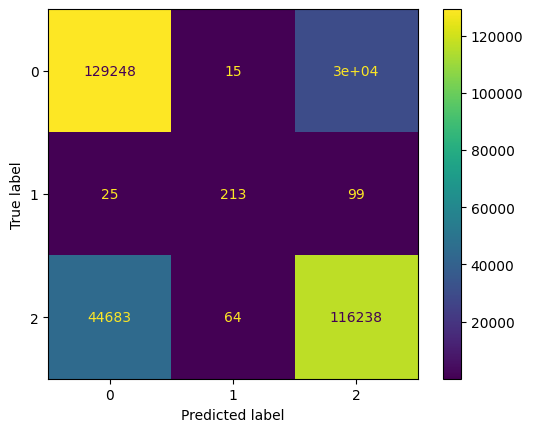

In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_val, axis=1)

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)
conf_matrix2 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_matrix2.plot()

report = classification_report(true_classes, predicted_classes, target_names=["Positive","Negative","Neutral"])
print("Classification Report:")
print(report)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1 Score: {f1:.5f}")

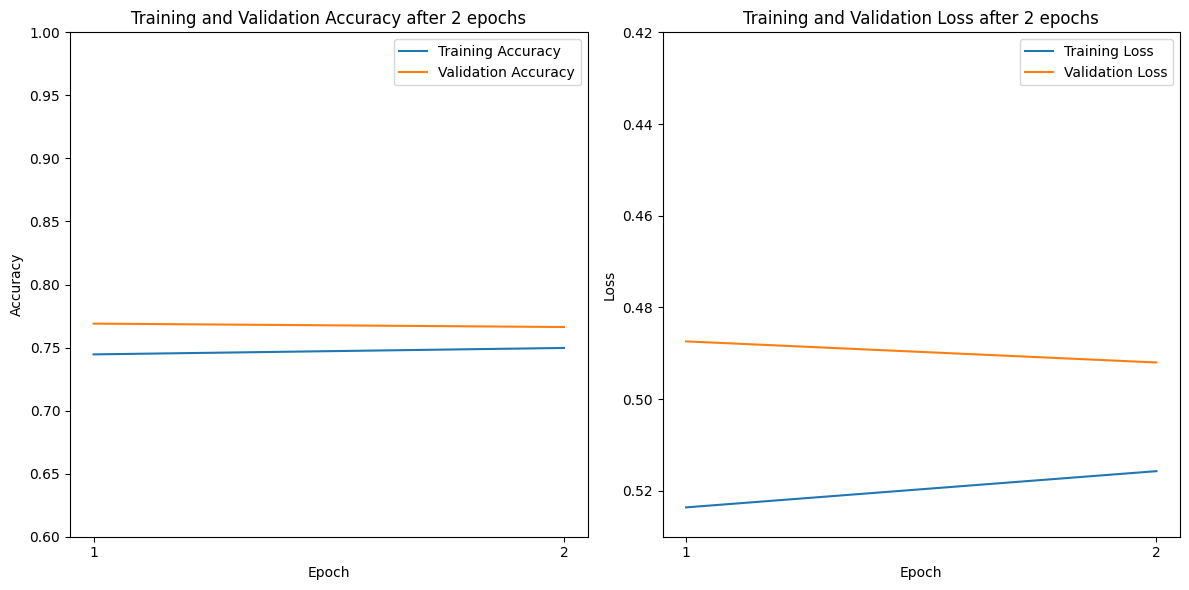

In [ ]:
#We plot the graphs using the values from the training epochs
import matplotlib.pyplot as plt
epochs = [1, 2]
train_accuracy = [0.7446, 0.7497]
validation_accuracy = [0.7690, 0.7663]
train_loss = [0.5236, 0.5157]
validation_loss = [0.4874, 0.4920]



plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy after 2 epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylim(0.6,1.0)
plt.xticks([1, 2])

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss after 2 epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.ylim(0.53,0.42)
plt.xticks([1, 2])

plt.tight_layout()
plt.show()
